In [1]:
from pathlib import Path
import os
import sys
import shutil
import numpy as np
import time
import datetime
import torch
import torch.nn as nn
import torchvision
import cfg
from datetime import datetime

from torchvision.utils import save_image, make_grid
# from tensorboardX import SummaryWriter

from types import SimpleNamespace

from models.ResNet import Res12_Quadratic, Res18_Quadratic, Res34_Quadratic

In [2]:
args = SimpleNamespace()
args.n_iter = 1000
args.num_sub = 5
args.batch_size = 16
args.in_chan = 1
args.n_chan = 64
args.n_gpus = 1
args.max_lr = 5e-5
args.min_noise = 0.1
args.max_noise = 3
args.noise_distribution = 'lin'
args.save_every = 500
args.dataset = 'fastmri'
args.cont = False
args.log = 'fastmri_EBM'
args.time = '' # timestamp to resume training
args.lr_schedule = 'cosine'
args.rand_seed = 42
args.net_indx = 1000
args.file_name = 'mdsm_ebm'
# args.classes = [0,1,2,3]
args.classes = [0]

In [3]:
torch.cuda.empty_cache()
torch.cuda.manual_seed(args.rand_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from data.fastmri_brain import inf_train_gen, inf_train_gen_downsampled
# itr = inf_train_gen(args.batch_size, num_sub=args.num_sub)
itr = inf_train_gen_downsampled(args.batch_size, num_sub=args.num_sub, device=device, res=64, complex_in=False, classes=args.classes)
netE = Res18_Quadratic(args.in_chan,args.n_chan,32,normalize=False,AF=nn.ELU())

netE = netE.to(device)

In [4]:
x_real = itr.__next__().to(device)

FLAIR_big_pickle - loading 5 of 108 subjects
min/max: tensor(0., dtype=torch.float64) / tensor(1.0000, dtype=torch.float64)
ksp: torch.Size([10, 12, 320, 320]) 	csm: torch.Size([10, 12, 320, 320])
min/max: tensor(0., dtype=torch.float64) / tensor(1.0000, dtype=torch.float64)
ksp: torch.Size([10, 12, 320, 320]) 	csm: torch.Size([10, 12, 320, 320])
min/max: tensor(0., dtype=torch.float64) / tensor(1., dtype=torch.float64)
ksp: torch.Size([10, 12, 320, 320]) 	csm: torch.Size([10, 12, 320, 320])
min/max: tensor(0., dtype=torch.float64) / tensor(1., dtype=torch.float64)
ksp: torch.Size([10, 12, 320, 320]) 	csm: torch.Size([10, 12, 320, 320])
min/max: tensor(0., dtype=torch.float64) / tensor(1., dtype=torch.float64)
ksp: torch.Size([10, 12, 320, 320]) 	csm: torch.Size([10, 12, 320, 320])
Loaded dataset of 50 slices

org torch.Size([50, 1, 320, 320])
Resizing to 64x64
Resized org: torch.Size([50, 1, 64, 64])


In [5]:
x_real.shape

torch.Size([16, 1, 64, 64])

0.0 0.49574882
0.0 0.46817294
0.0 0.47049734
0.0 0.63764256
0.0 0.50486034
0.0 0.530901
0.0 0.47258145
0.0 0.34493893
0.0 0.5618308
0.0 0.54595876
0.0 0.52910405
0.0 0.50932026
0.0 0.3546769
0.0 0.53415096
0.0 0.3358793
0.0 0.57973284


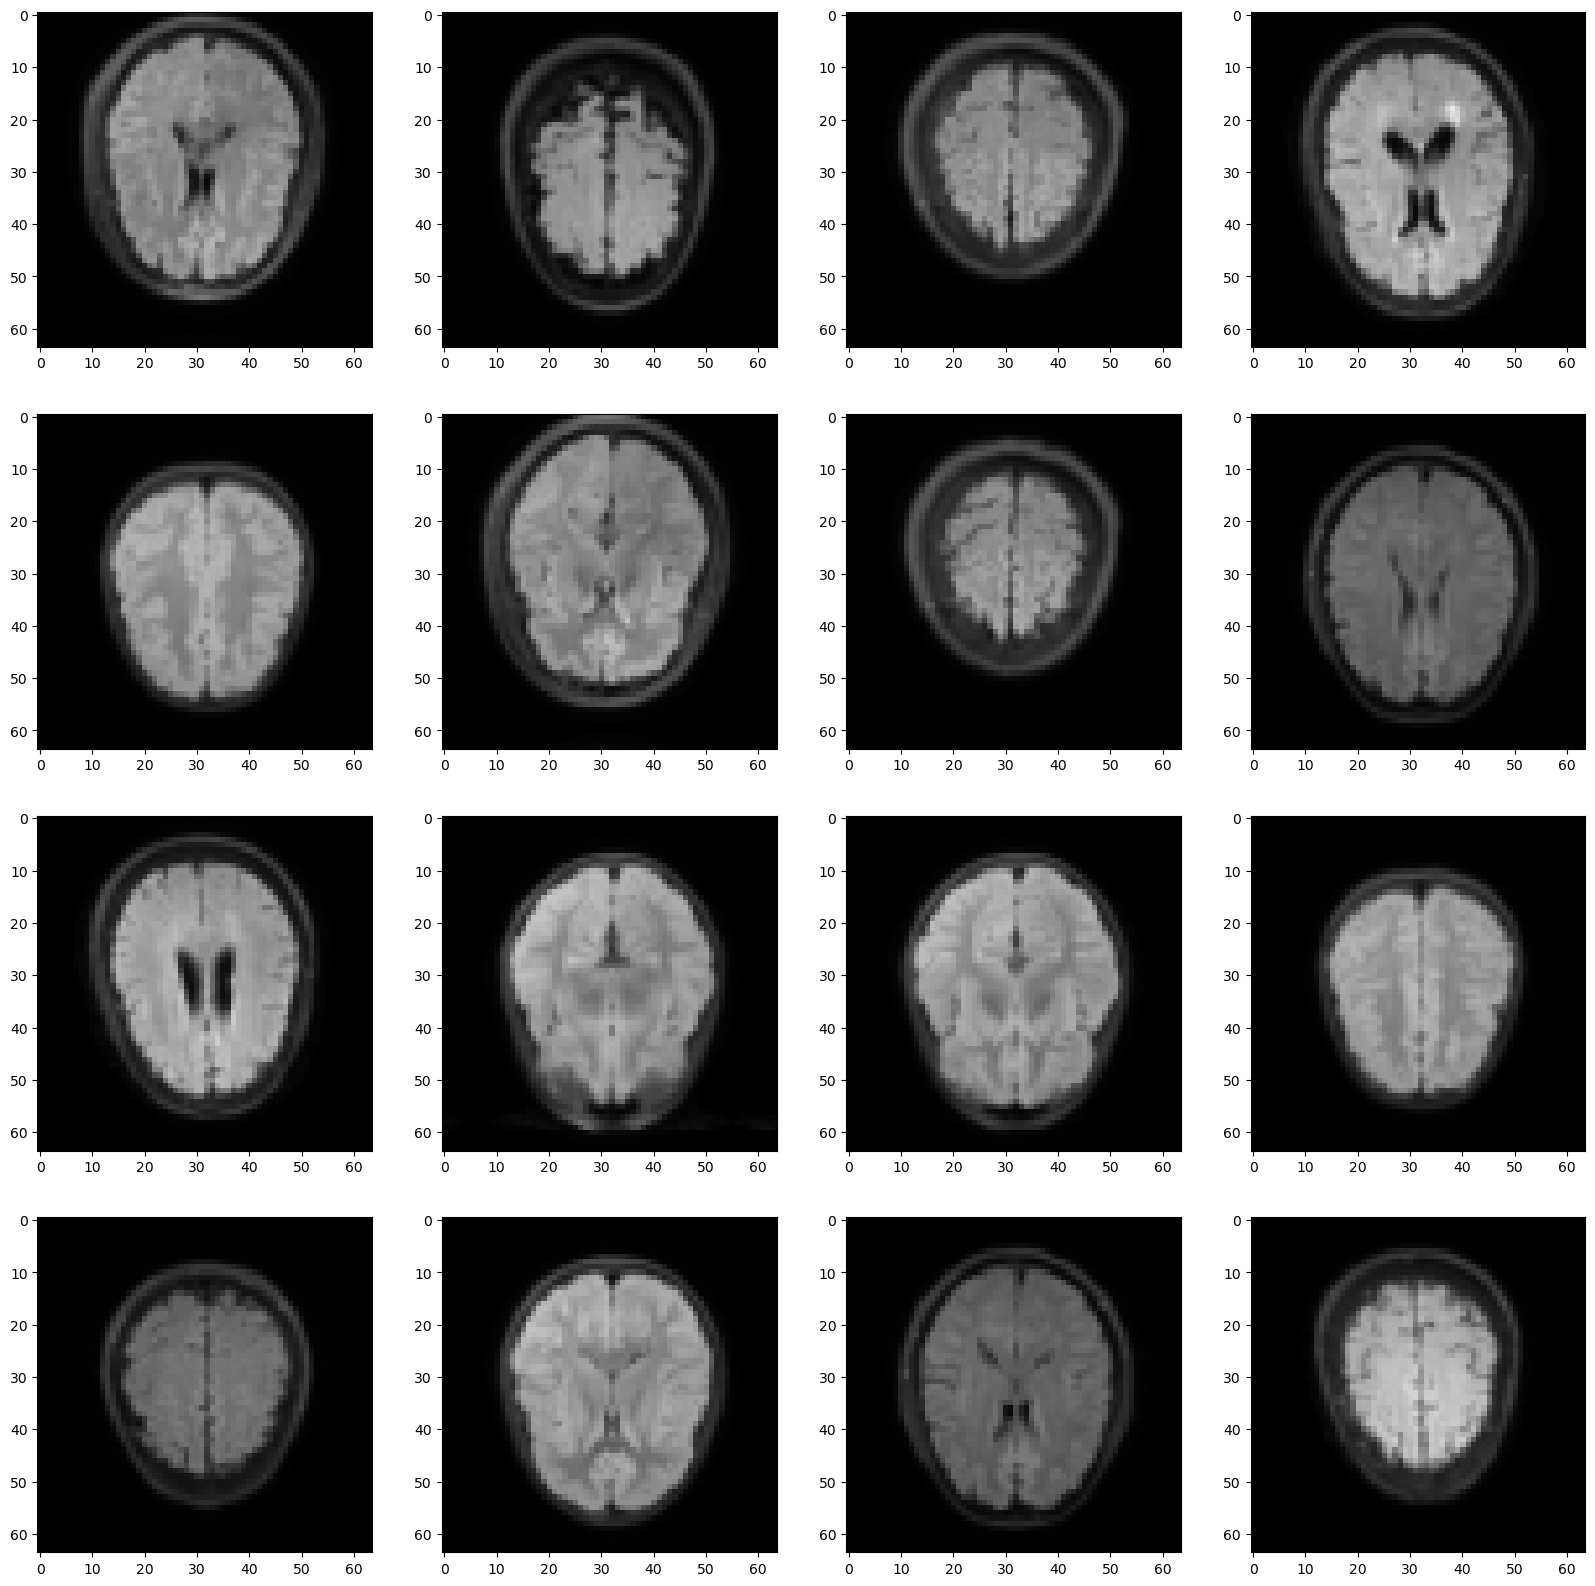

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        img = x_real[i*4+j,0].cpu().detach().numpy()
        print(img.min(), img.max())
        ax[i,j].imshow(img, cmap='gray',vmin=0.,vmax=0.7)
        # ax[i,j].imshow(x_real[i*4+j,0].cpu().detach().numpy(), cmap='gray')

In [7]:
x = []
for i in range(256//args.batch_size):
    x_real = itr.__next__()
    x.append(x_real)

x = torch.concat(x)

In [13]:
import matplotlib.colors as colors
def plot_sample(samples,grid_size,pad=2,vmax=1.0):
    #samples should be a torch tensor
    [Nsamples,Nchannels,Size_x,Size_y] = samples.shape
    
    
    last_step_denoise = make_grid(samples,normalize=False,nrow=grid_size[1],padding=pad).detach().cpu().numpy()
    last_step_denoise = np.moveaxis(last_step_denoise,0,2)
    
    n = colors.Normalize(vmin=0,vmax=vmax,clip=True)
    normalized=n(last_step_denoise)
    n_pix_column = grid_size[0]*Size_y + (grid_size[0]+1)*pad
    n_pix_row = grid_size[1]*Size_x + (grid_size[1]+1)*pad
    plt.figure(figsize=(n_pix_row/100*2,n_pix_column/100*2), dpi=100)
    plt.imshow(normalized, vmin=0, vmax=vmax)
    plt.axis('off')
    plt.show()

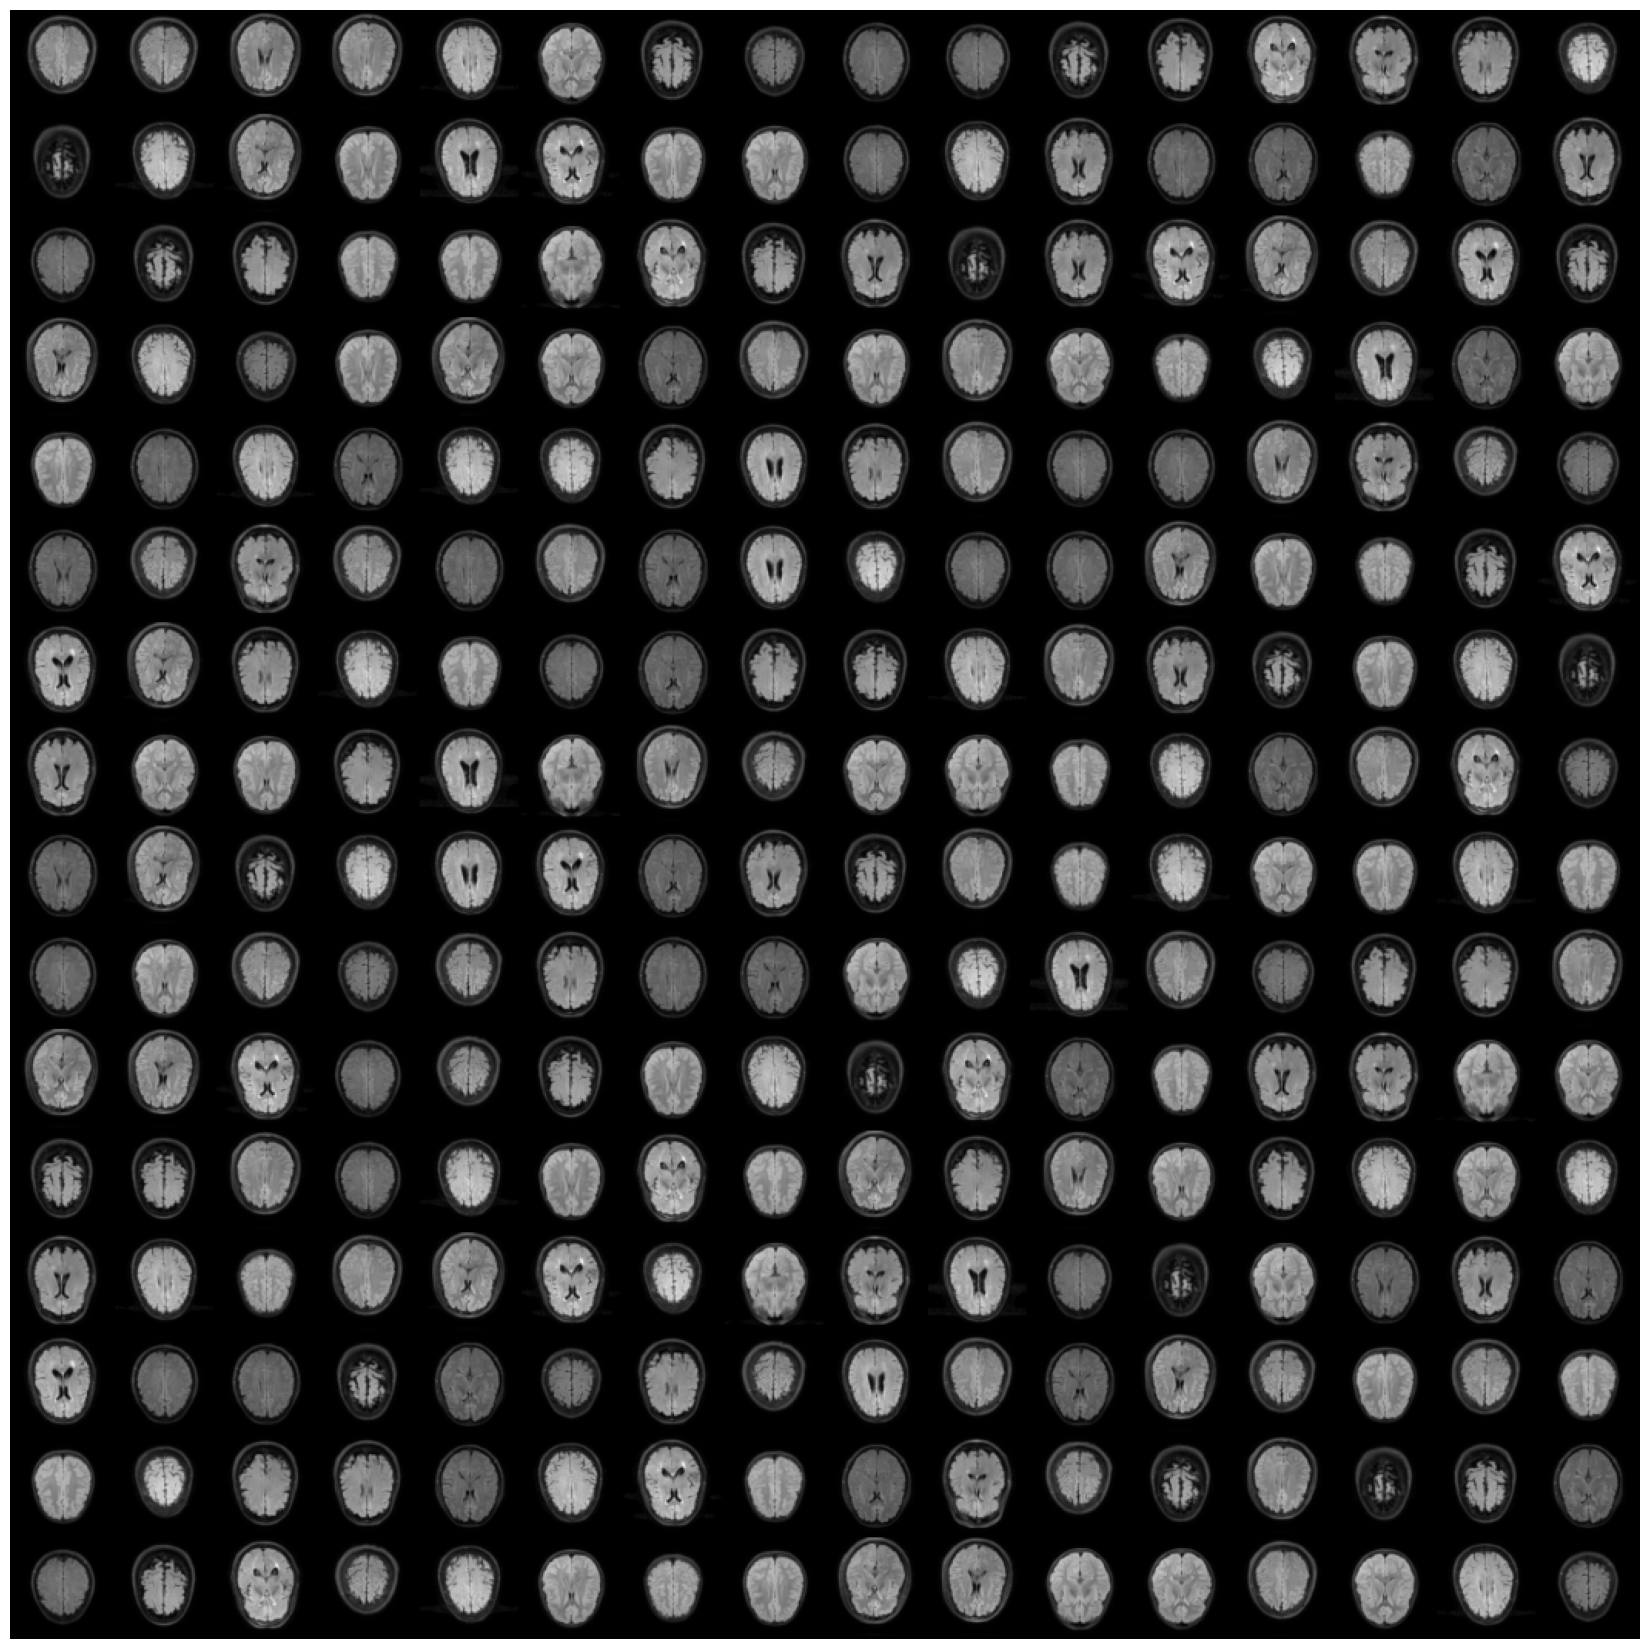

In [14]:
plot_sample(x, (16,16), vmax=0.7)